In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

Currently, your team is having difficulty on narrowing down the specific groups that should be targeted who are more likely to buy a cog. By looking at past customer information such as age, salary range, gender, and whether they purchased it or not, I want to find patterns to show who will and won't buy cogs. Once these patterns are found a model can be created to allow your team to target the correct audience, improve efficiency, and increase sales success.

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

The data was provided directly from the customer in the form of a CSV file. This dataset contains details such as customer age, gender, estimated salry, and whether or not they purchased or returned a cog.

In [7]:
import pandas as pd

df = pd.read_csv("Project_3.csv")

print(df.head())

print(df.info())
print(df.describe())


   User ID              name  Gender  Age  EstimatedSalary  Purchased
0    10000     Angela Davila    Male   23            19075          0
1    10001     John Mckinney    Male   31           147946          1
2    10002  Maureen Williams  Female   50            16690          0
3    10003  Stephanie Duarte  Female   33           133474          0
4    10004    Rebecca Graves  Female   54            75928          1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          1001 non-null   int64 
 1   name             1001 non-null   object
 2   Gender           1001 non-null   object
 3   Age              1001 non-null   int64 
 4   EstimatedSalary  1001 non-null   int64 
 5   Purchased        1001 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 47.0+ KB
None
            User ID          Age  EstimatedSalary    Purch

# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

Purchases are split between 50% not purchased, 46% purchased, and 4% returned. Middle-aged customer from 35-50 purchase at the highest rate, while younger customers from 20-30 are less likely. The highest salarites correlate with higher purchase rates. Gender is balanced with around 50/50. There may be bias because there are very few returned cases, so the model may not get much from the returns.

/tmp/ipykernel_551055/2113915633.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Purchase_Status_Label', data=df, palette='Set2')


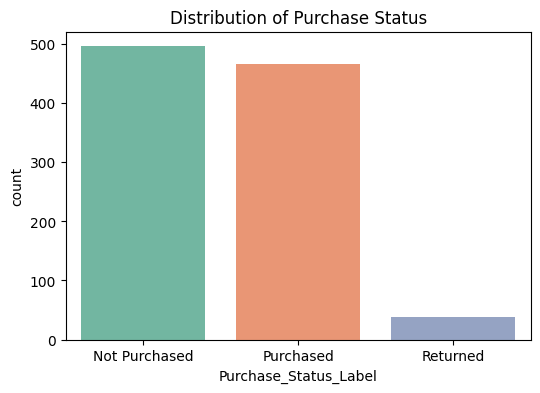

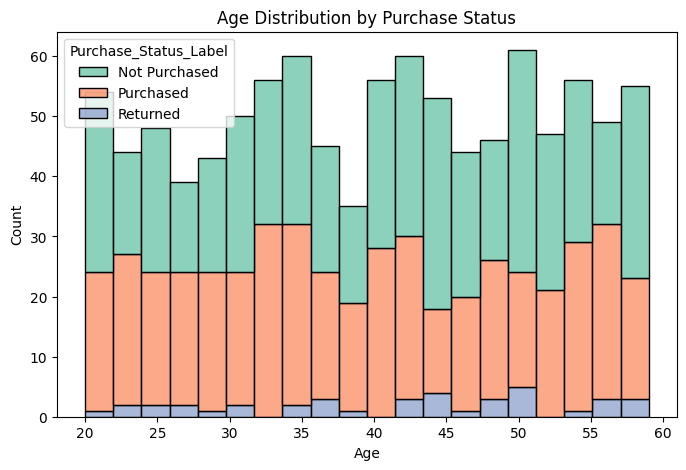

/tmp/ipykernel_551055/2113915633.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Purchase_Status_Label', y='EstimatedSalary',


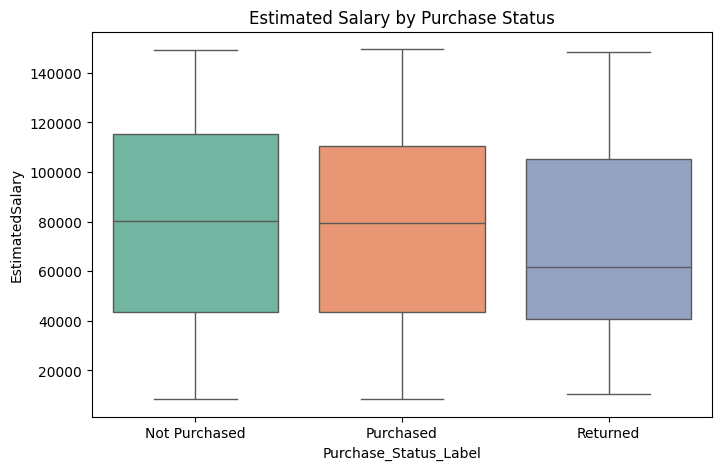

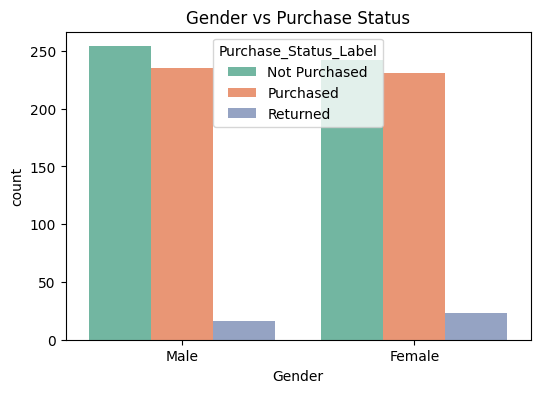

Bias Summary: {'gender_distribution': {'Male': 0.5044955044955045, 'Female': 0.4955044955044955}, 'age_distribution': {'count': 1001.0, 'mean': 39.94205794205794, 'std': 11.539958377768931, 'min': 20.0, '25%': 31.0, '50%': 40.0, '75%': 50.0, 'max': 59.0}, 'purchase_distribution': {0: 0.4955044955044955, 1: 0.46553446553446554, -1: 0.03896103896103896}}


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create purchase status labels
status_map = {-1: 'Returned', 0: 'Not Purchased', 1: 'Purchased'}
df['Purchase_Status_Label'] = df['Purchased'].map(status_map)

# Distribution of purchase status
plt.figure(figsize=(6,4))
sns.countplot(x='Purchase_Status_Label', data=df, palette='Set2')
plt.title("Distribution of Purchase Status")
plt.show()

# Age distribution by purchase status
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='Age', hue='Purchase_Status_Label',
             multiple='stack', bins=20, palette='Set2')
plt.title("Age Distribution by Purchase Status")
plt.show()

# Salary vs purchase status
plt.figure(figsize=(8,5))
sns.boxplot(x='Purchase_Status_Label', y='EstimatedSalary',
            data=df, palette='Set2')
plt.title("Estimated Salary by Purchase Status")
plt.show()

# Gender vs purchase status
plt.figure(figsize=(6,4))
sns.countplot(x='Gender', hue='Purchase_Status_Label',
              data=df, palette='Set2')
plt.title("Gender vs Purchase Status")
plt.show()

# Bias summary
bias_summary = {
    "gender_distribution": df['Gender'].value_counts(normalize=True).to_dict(),
    "age_distribution": df['Age'].describe().to_dict(),
    "purchase_distribution": df['Purchased'].value_counts(normalize=True).to_dict()
}
print("Bias Summary:", bias_summary)


# 4.Prepare the Data


Apply any data transformations and explain what and why


To clean the data I dropped irrelevant colunms like UserID and name since they don't help prediction. Then, I split the purchased column into 3 features: -1 = returned, 0 = not purchased, 1 = purchased. Then, I created bands to group continuous values into categories that may reveal patterns and dropped any rows with missing values. Finally, I split the data into training and testing data with a 80/20 split.

In [9]:
from sklearn.model_selection import train_test_split

# Drop identifiers
df_clean = df.drop(columns=["User ID", "name"], errors="ignore")

# Rename target column
df_clean = df_clean.rename(columns={"Purchased": "Purchase_Status"})

# Ensure target values are consistent
df_clean["Purchase_Status"] = df_clean["Purchase_Status"].replace({2: -1})
df_clean["Purchase_Status"] = df_clean["Purchase_Status"].astype(int)

# Create Age Bands
df_clean["Age_Band"] = pd.cut(
    df_clean["Age"], bins=[0, 25, 35, 50, 60],
    labels=["<25", "25-35", "36-50", "51+"]
)

# Create Salary Bands
df_clean["Salary_Band"] = pd.cut(
    df_clean["EstimatedSalary"],
    bins=[0, 50000, 100000, 150000],
    labels=["Low", "Medium", "High"]
)

# Drop missing values if any
df_clean = df_clean.dropna()

# Split features and target
X = df_clean.drop(columns=["Purchase_Status"])
y = df_clean["Purchase_Status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Data prepared")
print("Training shape:", X_train.shape, "Test shape:", X_test.shape)
print(df_clean.head())


Data prepared
Training shape: (800, 6) Test shape: (201, 6)
   Gender  Age  EstimatedSalary  Purchase_Status Purchase_Status_Label  \
0    Male   23            19075                0         Not Purchased   
1    Male   31           147946                1             Purchased   
2  Female   50            16690                0         Not Purchased   
3  Female   33           133474                0         Not Purchased   
4  Female   54            75928                1             Purchased   

  Age_Band Salary_Band  
0      <25         Low  
1    25-35        High  
2    36-50         Low  
3    25-35        High  
4      51+      Medium  


# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [ ]:
def infrence(prams):
    results = m.run(prams)
    return results 

✅ Data cleaned and split successfully
Training shape: (800, 5) Test shape: (201, 5)


/tmp/ipykernel_551055/191016435.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Purchase_Status_Label', data=df, palette='Set2', ax=ax1)
/tmp/ipykernel_551055/191016435.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Purchase_Status_Label', y='EstimatedSalary',



Bias Summary:
{'gender_distribution': {'Male': 0.5044955044955045, 'Female': 0.4955044955044955}, 'age_distribution': {'count': 1001.0, 'mean': 39.94205794205794, 'std': 11.539958377768931, 'min': 20.0, '25%': 31.0, '50%': 40.0, '75%': 50.0, 'max': 59.0}, 'purchase_distribution': {0: 0.4955044955044955, 1: 0.46553446553446554, -1: 0.03896103896103896}}


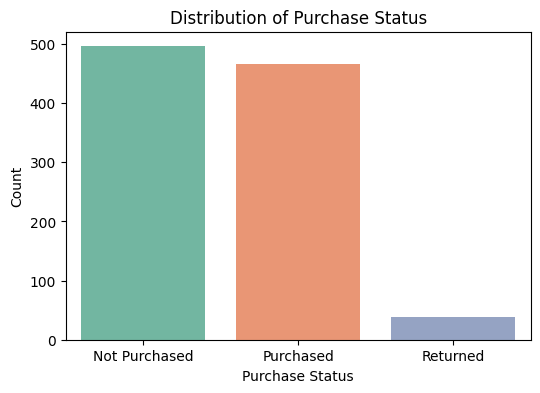

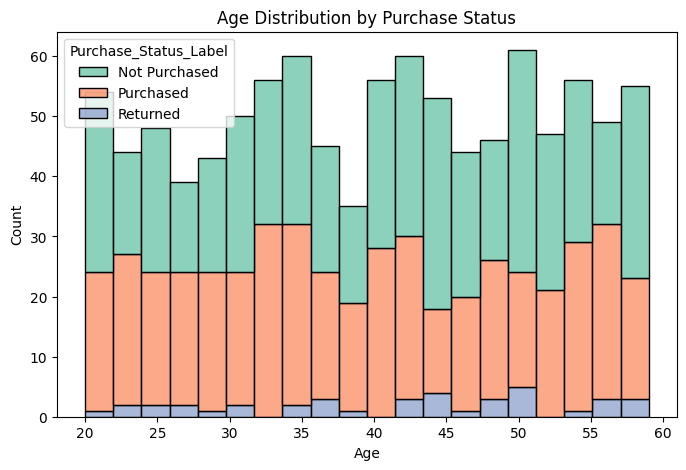

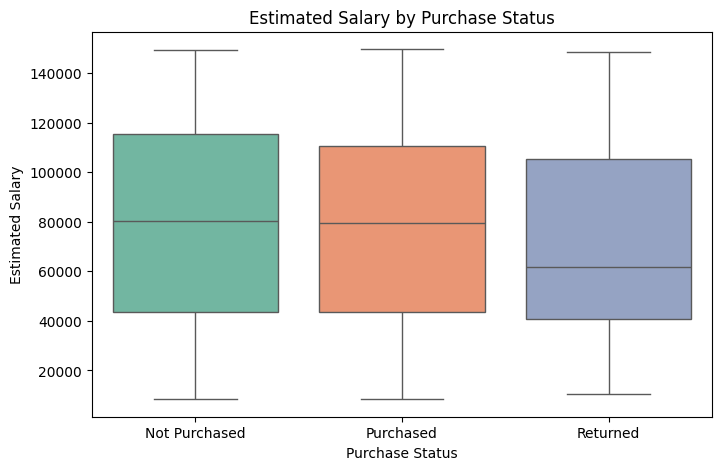

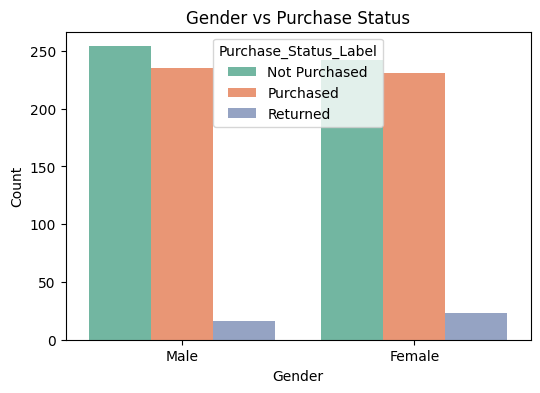

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# ================================
# 1. Load and Clean the Data
# ================================
df = pd.read_csv("Project_3.csv")

# Drop identifiers (not useful for prediction)
df = df.drop(columns=["User ID", "name"], errors="ignore")

# Rename target column for clarity
df = df.rename(columns={"Purchased": "Purchase_Status"})

# Ensure target has -1 (Returned), 0 (Not Purchased), 1 (Purchased)
df["Purchase_Status"] = df["Purchase_Status"].replace({2: -1})
df["Purchase_Status"] = df["Purchase_Status"].astype(int)

# Create Age Bands
df["Age_Band"] = pd.cut(
    df["Age"],
    bins=[0, 25, 35, 50, 60],
    labels=["<25", "25-35", "36-50", "51+"]
)

# Create Salary Bands
df["Salary_Band"] = pd.cut(
    df["EstimatedSalary"],
    bins=[0, 50000, 100000, 150000],
    labels=["Low", "Medium", "High"]
)

# Remove missing values (if any)
df = df.dropna()

# Train/test split
X = df.drop(columns=["Purchase_Status"])
y = df["Purchase_Status"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ Data cleaned and split successfully")
print("Training shape:", X_train.shape, "Test shape:", X_test.shape)

# ================================
# 2. Graphs for Exploration
# ================================

status_map = {-1: 'Returned', 0: 'Not Purchased', 1: 'Purchased'}
df["Purchase_Status_Label"] = df["Purchase_Status"].map(status_map)

# Plot 1: Distribution of purchase status
fig1, ax1 = plt.subplots(figsize=(6,4))
sns.countplot(x='Purchase_Status_Label', data=df, palette='Set2', ax=ax1)
ax1.set_title("Distribution of Purchase Status")
ax1.set_xlabel("Purchase Status")
ax1.set_ylabel("Count")

# Plot 2: Age distribution by purchase status
fig2, ax2 = plt.subplots(figsize=(8,5))
sns.histplot(data=df, x='Age', hue='Purchase_Status_Label',
             multiple='stack', bins=20, palette='Set2', ax=ax2)
ax2.set_title("Age Distribution by Purchase Status")
ax2.set_xlabel("Age")
ax2.set_ylabel("Count")

# Plot 3: Estimated Salary vs Purchase Status
fig3, ax3 = plt.subplots(figsize=(8,5))
sns.boxplot(x='Purchase_Status_Label', y='EstimatedSalary',
            data=df, palette='Set2', ax=ax3)
ax3.set_title("Estimated Salary by Purchase Status")
ax3.set_xlabel("Purchase Status")
ax3.set_ylabel("Estimated Salary")

# Plot 4: Gender vs Purchase Status
fig4, ax4 = plt.subplots(figsize=(6,4))
sns.countplot(x='Gender', hue='Purchase_Status_Label',
              data=df, palette='Set2', ax=ax4)
ax4.set_title("Gender vs Purchase Status")
ax4.set_xlabel("Gender")
ax4.set_ylabel("Count")

# ================================
# 3. Bias Summary
# ================================
bias_summary = {
    "gender_distribution": df['Gender'].value_counts(normalize=True).to_dict(),
    "age_distribution": df['Age'].describe().to_dict(),
    "purchase_distribution": df['Purchase_Status'].value_counts(normalize=True).to_dict()
}

print("\nBias Summary:")
print(bias_summary)

# Optional: Save graphs instead of showing
# fig1.savefig("purchase_status_distribution.png")
# fig2.savefig("age_by_purchase.png")
# fig3.savefig("salary_by_purchase.png")
# fig4.savefig("gender_by_purchase.png")
